<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/CSD485_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS485: Data Science and Applications
## Assignment 7
### Vasileios Papageridis - csd4710

---

# Introduction to Graph Neural Networks with PyTorch

# HOMEWORK 7

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.2+cpu
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Load the dataset

In [2]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')

# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


**Define a GCN network**


In [3]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class NodeClassificationGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(NodeClassificationGCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

**Visualize the node embeddings of the untrained GCN network using PCA (or t-SNE if you are or want to get familiar with it)**

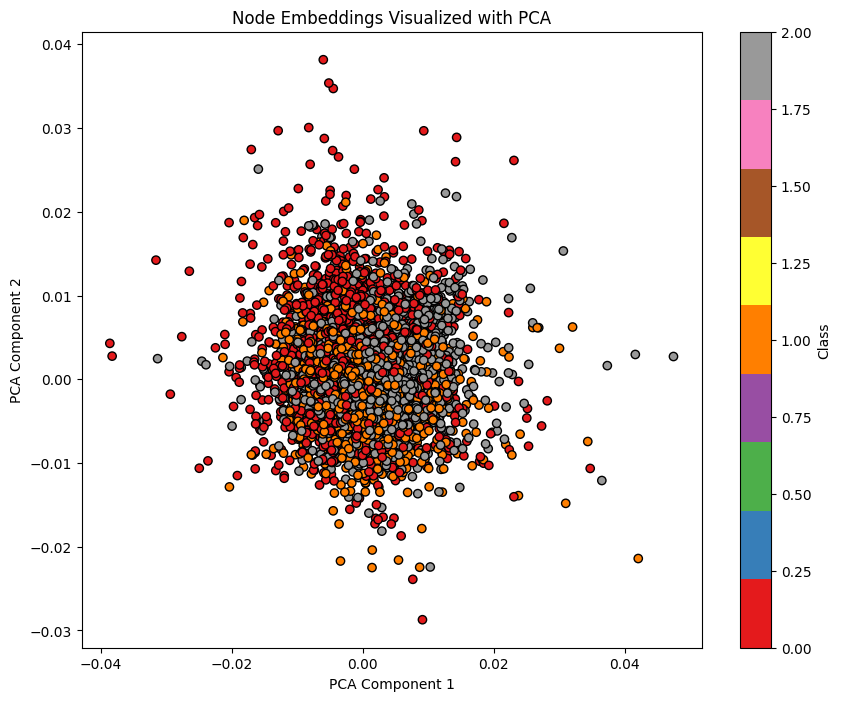

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

model = NodeClassificationGCN(num_node_features=dataset.num_node_features, num_classes=dataset.num_classes, hidden_channels=64)

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

node_embeddings = out.detach().cpu().numpy()
pca = PCA(n_components=2)
node_embeddings_pca = pca.fit_transform(node_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_pca[:, 0], node_embeddings_pca[:, 1], c=data.y, cmap='Set1', edgecolor='k')
plt.title('Node Embeddings Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Class')
plt.show()

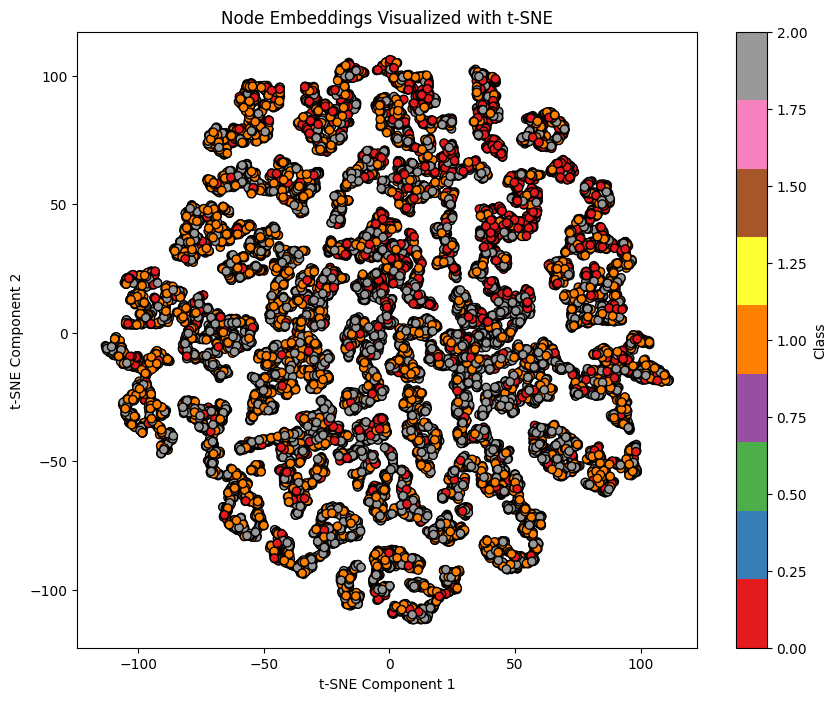

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random')
node_embeddings_tsne = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_tsne[:, 0], node_embeddings_tsne[:, 1], c=data.y, cmap='Set1', edgecolor='k')
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Class')
plt.show()

**Perform a grid search hyperparameter tuning for the following parameters:**
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

PS: Remember, first you need to split the data into training, validation and test sets.

In [6]:
import torch
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from sklearn.model_selection import ParameterGrid

dataset = Planetoid(root='data/Planetoid', name='PubMed')
data = dataset[0]

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

param_grid = {
    'num_layers': [2, 3, 4],
    'hidden_dim': [16, 32, 64, 128],
    'learning_rate': [0.01, 0.005, 0.001],
    'dropout_rate': [0.5, 0.7, 0.3],
}

best_val_performance = float('-inf')
best_params = None

for params in ParameterGrid(param_grid):
    print("Testing parameters:", params)
    model = NodeClassificationGCN(dataset.num_node_features, dataset.num_classes, params['hidden_dim'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0 or epoch == 199:  # Log every 10 epochs
            model.eval()
            _, pred = model(data.x, data.edge_index).max(dim=1)
            correct = pred[val_mask].eq(data.y[val_mask]).sum().item()
            val_accuracy = correct / int(val_mask.sum())
            print(f"Epoch {epoch+1}: Loss = {loss.item()}, Validation Accuracy = {val_accuracy}")

            if val_accuracy > best_val_performance:
                best_val_performance = val_accuracy
                best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_val_performance}")


Testing parameters: {'dropout_rate': 0.5, 'hidden_dim': 16, 'learning_rate': 0.01, 'num_layers': 2}
Epoch 1: Loss = 1.10002601146698, Validation Accuracy = 0.462
Epoch 11: Loss = 0.961315393447876, Validation Accuracy = 0.704
Epoch 21: Loss = 0.6190271973609924, Validation Accuracy = 0.73
Epoch 31: Loss = 0.3962092101573944, Validation Accuracy = 0.776
Epoch 41: Loss = 0.19331486523151398, Validation Accuracy = 0.768
Epoch 51: Loss = 0.13161124289035797, Validation Accuracy = 0.776
Epoch 61: Loss = 0.06287644058465958, Validation Accuracy = 0.77
Epoch 71: Loss = 0.03632333129644394, Validation Accuracy = 0.776
Epoch 81: Loss = 0.04257259890437126, Validation Accuracy = 0.774
Epoch 91: Loss = 0.018460260704159737, Validation Accuracy = 0.778
Epoch 101: Loss = 0.00861487165093422, Validation Accuracy = 0.772
Epoch 111: Loss = 0.012821209616959095, Validation Accuracy = 0.776
Epoch 121: Loss = 0.026416437700390816, Validation Accuracy = 0.756
Epoch 131: Loss = 0.015695838257670403, Valida

**Train the GCN model with the optimal hyperparameters**
 - Select the best model based on the highest validation performance (lowest validation loss).*italicized text*
 - Save the best model to load it later for the final evaluation process.

In [7]:
data = dataset[0]

# From the grid search result
optimal_params = {
    'hidden_dim': 16,
    'learning_rate': 0.005,
    'dropout_rate': 0.5,
    'num_layers': 2
}

model = NodeClassificationGCN(dataset.num_node_features, dataset.num_classes, optimal_params['hidden_dim'])
optimizer = optim.Adam(model.parameters(), lr=optimal_params['learning_rate'])
criterion = torch.nn.CrossEntropyLoss()

In [8]:
train_val_mask = data.train_mask | data.val_mask

best_val_loss = float('inf')
best_model_state = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_val_mask], data.y[train_val_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss.item()}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

torch.save(best_model_state, 'best_gcn_model.pth')
print('Saved the best model based on validation loss.')

Epoch 1, Validation Loss: 1.095668077468872
Epoch 2, Validation Loss: 1.0921003818511963
Epoch 3, Validation Loss: 1.0882933139801025
Epoch 4, Validation Loss: 1.0841259956359863
Epoch 5, Validation Loss: 1.079404354095459
Epoch 6, Validation Loss: 1.0741370916366577
Epoch 7, Validation Loss: 1.0687341690063477
Epoch 8, Validation Loss: 1.0629159212112427
Epoch 9, Validation Loss: 1.0561472177505493
Epoch 10, Validation Loss: 1.0487086772918701
Epoch 11, Validation Loss: 1.0408194065093994
Epoch 12, Validation Loss: 1.0325794219970703
Epoch 13, Validation Loss: 1.0239238739013672
Epoch 14, Validation Loss: 1.0148249864578247
Epoch 15, Validation Loss: 1.0051251649856567
Epoch 16, Validation Loss: 0.9946127533912659
Epoch 17, Validation Loss: 0.9832152724266052
Epoch 18, Validation Loss: 0.9712008833885193
Epoch 19, Validation Loss: 0.9585939645767212
Epoch 20, Validation Loss: 0.9455941915512085
Epoch 21, Validation Loss: 0.9319713711738586
Epoch 22, Validation Loss: 0.9177425503730774

In [9]:
model.load_state_dict(torch.load('best_gcn_model.pth'))

model.eval()
with torch.no_grad():
    test_out = model(data.x, data.edge_index)
    test_loss = criterion(test_out[data.test_mask], data.y[data.test_mask])
    _, test_pred = test_out.max(dim=1)
    correct = test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = correct / int(data.test_mask.sum())
    print(f'Test Loss: {test_loss.item()}, Test Accuracy: {test_acc}')


Test Loss: 0.7198705077171326, Test Accuracy: 0.806


**Visualize the output embeddings of your trained model. What do you observe?**

In [10]:
model.load_state_dict(torch.load('best_gcn_model.pth'))
model.eval()

with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

tsne = TSNE(n_components=2, learning_rate='auto', init='random')
node_embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

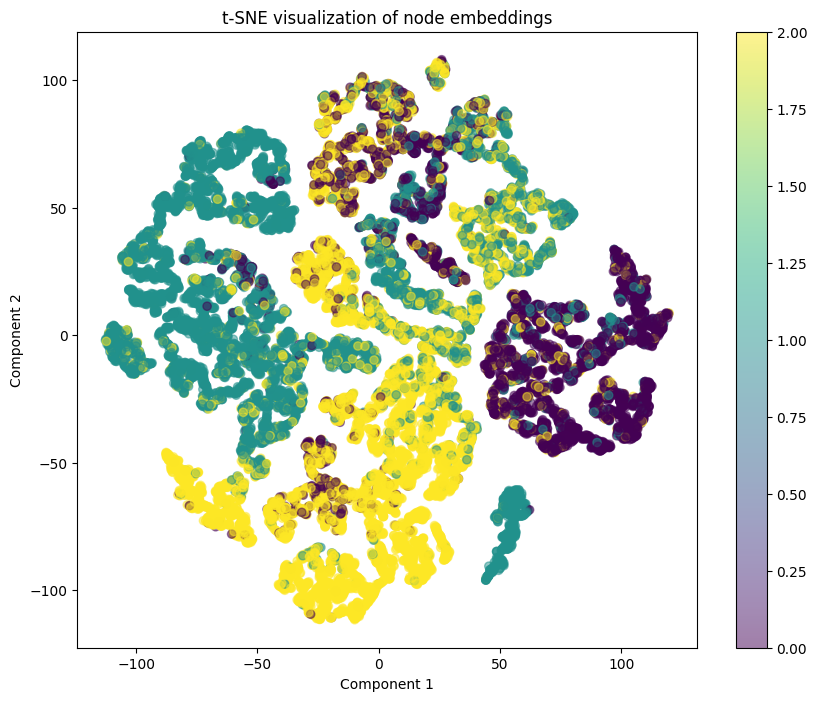

In [11]:
color_map = data.y.detach().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=color_map, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of node embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## t-SNE Visualization Observations

### Clusters
- The visualization shows distinct groupings or **clusters** of nodes. This clustering is a positive indication that the model has learned to embed nodes with similar features or labels close to each other in the embedding space.

### Class Separation
- Nodes appear to be colored based on their class labels, which range from 0 to 2. There is a visible **separation between classes**, suggesting that the model embeddings capture class-specific information effectively.

### Overlap Between Classes
- Certain regions in the plot show **overlap between different colors**. These overlaps suggest that there are nodes with similar embeddings despite belonging to different classes, which could be due to similarities in their features or more challenging distinctions for the model to learn.

### Outliers
- A few nodes are situated away from the central clusters. These **outliers** might represent unique node features within their classes or potential anomalies in the dataset. They might also indicate nodes that the model finds difficult to classify accurately.

Overall, the t-SNE provides valuable insights. **Well-defined clusters** are a strong indicator of a model's good performance, while **overlaps and outliers** may suggest areas for further model tuning or data inspection.


**Evaluate the trained model on the test set and report the classification accuracy**

In [12]:

data = dataset[0]

model = NodeClassificationGCN(dataset.num_node_features, dataset.num_classes, 16)
model.load_state_dict(torch.load('best_gcn_model.pth'))
model.eval()

with torch.no_grad():
    test_logits = model(data.x, data.edge_index)
    test_probs = torch.softmax(test_logits, dim=1)
    test_preds = test_probs.argmax(dim=1)
    correct = test_preds[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_accuracy = correct / data.test_mask.sum().item()

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8060
